In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import random
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import shap
import dice_ml

In [ ]:
daily_por_tramo = pd.read_csv("daily_por_tramo_4_2.csv", index_col=0)

print("✅ Dataset cargado correctamente.")

✅ Dataset cargado correctamente.


In [ ]:
vars_ambientales = ['TA', 'HA', 'radiacion', 'precipitacion', 'eto']
vars_suelo       = ['HS10','HS20','HS30','HS40','HS50','HS6','TS30','litros_diarios']
VENTANA = 4

def build_windowed_df(df, vars_ambientales_base, vars_suelo_base, ventana=4):
    rows = []
    # empezamos en i=1 para tener t-1; terminamos en len-ventana para poder acceder hasta t+ventana
    for i in range(1, len(df) - ventana):
        t = df.index[i]
        y = int(df.iloc[i + ventana]['CMNDT'] < 0)  # clase objetivo
        feats = {'fecha': t, 'y': y}

        # a) variables ambientales desde t-1 hasta t+ventana
        for base in vars_ambientales_base:
            cols = [c for c in df.columns if c.startswith(base)]
            for col in cols:
                for offset in range(-1, ventana + 1):
                    if offset < 0:
                        suffix = f"_t{offset}"
                    elif offset == 0:
                        suffix = "_t0"
                    else:
                        suffix = f"_t+{offset}"
                    colname = f"{col}{suffix}"
                    feats[colname] = df.iloc[i + offset][col]

        # b) variables de suelo desde t0 hasta t+ventana
        for base in vars_suelo_base:
            cols = [c for c in df.columns if c.startswith(base)]
            for col in cols:
                for offset in range(0, ventana + 1):
                    if offset == 0:
                        suffix = "_t0"
                    else:
                        suffix = f"_t+{offset}"
                    colname = f"{col}{suffix}"
                    feats[colname] = df.iloc[i + offset][col]

        rows.append(feats)

    return pd.DataFrame(rows).set_index('fecha')

df_src = daily_por_tramo.copy()

df_series = build_windowed_df(df_src, vars_ambientales, vars_suelo, VENTANA)


IMPORTANCIA VARIABLES

In [ ]:

SEED = 7
random.seed(SEED)
np.random.seed(SEED)

X = df_series.drop(columns=['y'])
y = df_series['y']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    stratify=y,
    random_state=SEED
)

rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    min_samples_split=2,
    max_features=None,
    random_state=SEED
)
rf.fit(X_train, y_train)

xgb = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    colsample_bytree=1,
    learning_rate=0.1,
    max_depth=3,
    n_estimators=100,
    subsample=0.8,
    random_state=SEED
)
xgb.fit(X_train, y_train)

importances_rf  = rf.feature_importances_
importances_xgb = xgb.feature_importances_

df_imp = pd.DataFrame({
    'variable': X.columns,
    'importance_rf': importances_rf,
    'importance_xgb': importances_xgb
})
df_imp['mean_imp'] = df_imp[['importance_rf', 'importance_xgb']].mean(axis=1)

# ————— 6. Ordenar por importancia descendente —————
df_imp = df_imp.sort_values(by='mean_imp', ascending=False).reset_index(drop=True)

# ————— 7. Acumulación hasta el 80% —————
df_imp['cumulative_importance'] = df_imp['mean_imp'].cumsum()

umbral= 0.5
selected_vars = df_imp[df_imp['cumulative_importance'] <= umbral]['variable'].tolist()

print(f'Variables seleccionadas f({int(umbral * 100)}% acumulado):', selected_vars)
print("Total seleccionadas:", len(selected_vars))

Variables seleccionadas f(50% acumulado): ['TA_max_t+4', 'eto_t+3', 'HA_min_t+4', 'TA_min_t+1', 'HS10_min_t0', 'HS50_max_t+1', 'precipitacion_t+3', 'radiacion_t-1', 'HA_min_t+3', 'HA_mean_t+3', 'HS60_min_t0', 'HS30_mean_t+3', 'HS20_mean_t+3', 'HS60_min_t+1', 'eto_t+2', 'radiacion_t+3', 'HS10_min_t+2', 'HS60_max_t+4', 'TA_mean_t+4', 'TA_min_t-1']
Total seleccionadas: 20


In [ ]:
import matplotlib.pyplot as plt

# Ordenar por importancia media y calcular acumuladas
df_imp = df_imp.sort_values('mean_imp', ascending=False).reset_index(drop=True)
df_imp['cumulative'] = df_imp['mean_imp'].cumsum()

# Filtrar solo las primeras 50 variables
df_plot = df_imp.iloc[:50].copy()

fig, ax1 = plt.subplots(figsize=(15, 6), dpi=1000)

color_bar = 'tab:blue'
ax1.bar(df_plot['variable'], df_plot['mean_imp'], color=color_bar, alpha=0.7)
ax1.set_ylabel('Importancia media', color=color_bar, fontsize=13)
ax1.set_xlabel('Variable', fontsize=13)
ax1.tick_params(axis='y', labelcolor=color_bar, labelsize=11)
ax1.tick_params(axis='x', labelsize=10)
ax1.set_xticks(range(len(df_plot)))
ax1.set_xticklabels(df_plot['variable'], rotation=45, ha='right', fontsize=10)
ax1.set_ylim(0, 0.10) 

ax2 = ax1.twinx()
color_line = 'tab:orange'
ax2.plot(df_plot['variable'], df_plot['cumulative'], color=color_line, marker='o', label='Importancia acumulada')
ax2.axhline(y=umbral, color='red', linestyle='--', label=f'Umbral {umbral * 100}%')
ax2.set_ylabel('Importancia acumulada', color=color_line, fontsize=13)
ax2.tick_params(axis='y', labelcolor=color_line, labelsize=11)
ax2.set_ylim(0, 1) 

ax2.legend(loc='upper center', fontsize=11)

plt.tight_layout()
plt.show()

In [41]:
# Filtrar train y test 
X_train_sel = X_train[selected_vars]
X_test_sel  = X_test[selected_vars]

Fitting 5 folds for each of 81 candidates, totalling 405 fits


c:\Users\Carla\Programas\ANACONDA2\envs\tfg_explicador\lib\site-packages\xgboost\training.py:183: UserWarning: [02:57:37] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Carla\Programas\ANACONDA2\envs\tfg_explicador\lib\site-packages\xgboost\training.py:183: UserWarning: [02:57:37] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Carla\Programas\ANACONDA2\envs\tfg_explicador\lib\site-packages\xgboost\training.py:183: UserWarning: [02:57:37] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Carla\Programas\ANACONDA2\envs\tfg_explicador\lib\site-packages\xgboost\training.py:183: UserWarning: [02:57:37] WARNING: C:\actio


 Mejores hiperparámetros encontrados:
  - colsample_bytree: 0.85
  - learning_rate: 0.1
  - max_depth: 2
  - n_estimators: 100

===== Resultados XGBoost con GridSearch =====
F1-score: 0.894
Accuracy: 0.907
              precision    recall  f1-score   support

   crece (0)       0.90      1.00      0.95        35
 decrece (1)       1.00      0.50      0.67         8

    accuracy                           0.91        43
   macro avg       0.95      0.75      0.81        43
weighted avg       0.92      0.91      0.89        43



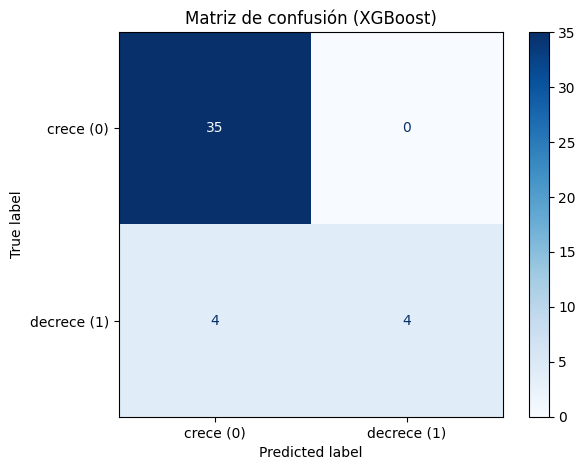

In [ ]:
# ==== MODELO BASE ====
xgb_base = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    objective='binary:logistic',
    random_state=7
)

# ==== GRID DE HIPERPARÁMETROS ====
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [2, 3, 4],
    'learning_rate': [0.01, 0.05, 0.1],
    'colsample_bytree': [0.7, 0.85, 1.0]
}

# ==== BÚSQUEDA CON VALIDACIÓN CRUZADA ====
grid = GridSearchCV(
    estimator=xgb_base,
    param_grid=param_grid,
    scoring='f1_weighted',
    cv=5,
    n_jobs=1,
    verbose=1
)

grid.fit(X_train_sel, y_train)

# ==== MEJOR MODELO ====
xgb_best = grid.best_estimator_

print("\n Mejores hiperparámetros encontrados:")
for param, value in grid.best_params_.items():
    print(f"  - {param}: {value}")

# ==== PREDICCIONES ====
y_pred_xgb = xgb_best.predict(X_test_sel)
y_prob_test_xgb = xgb_best.predict_proba(X_test_sel)

# ==== EVALUACIÓN ====
print("\n===== Resultados XGBoost con GridSearch =====")
print(f"F1-score: {f1_score(y_test, y_pred_xgb, average='weighted'):.3f}")
print(f"Accuracy: {accuracy_score(y_test, y_pred_xgb):.3f}")
print(classification_report(y_test, y_pred_xgb, target_names=['crece (0)', 'decrece (1)']))

# ==== MATRIZ DE CONFUSIÓN ====
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
disp_xgb = ConfusionMatrixDisplay(cm_xgb, display_labels=['crece (0)', 'decrece (1)'])
disp_xgb.plot(cmap='Blues')
plt.title("Matriz de confusión (XGBoost)")
plt.grid(False)
plt.tight_layout()
plt.show()


===== Evaluación con matriz de costes (XGBoost) =====
F1-score (cost-sensitive): 0.841
Accuracy (cost-sensitive): 0.837
              precision    recall  f1-score   support

   crece (0)       0.91      0.89      0.90        35
 decrece (1)       0.56      0.62      0.59         8

    accuracy                           0.84        43
   macro avg       0.73      0.76      0.74        43
weighted avg       0.85      0.84      0.84        43



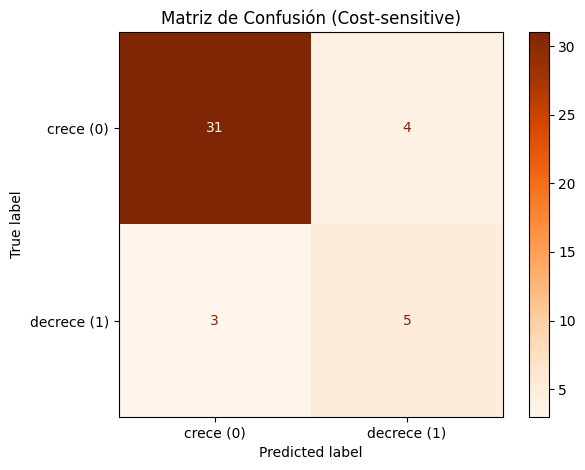

In [45]:
# Definimos la matriz de costes:
# C[i,j] = coste de predecir j cuando la verdadera es i
C = np.array([
    [0, 5],   # clase real = 0 (crece), predecir 1 cuesta 5
    [15, 0]   # clase real = 1 (decrece), predecir 0 cuesta 15
])

# y_prob_test_xgb tiene shape (n_samples, 2) y columnas [P(clase=0), P(clase=1)]
# Calculamos coste esperado para cada clase predicha
cost_expected = y_prob_test_xgb.dot(C)  # (n_samples, 2)

# Elegimos la clase con menor coste esperado para cada muestra
y_pred_cost = np.argmin(cost_expected, axis=1)

# Evaluación coste-sensitiva
print("\n===== Evaluación con matriz de costes (XGBoost) =====")
print(f"F1-score (cost-sensitive): {f1_score(y_test, y_pred_cost, average='weighted'):.3f}")
print(f"Accuracy (cost-sensitive): {accuracy_score(y_test, y_pred_cost):.3f}")
print(classification_report(y_test, y_pred_cost, target_names=['crece (0)', 'decrece (1)']))

# Matriz de confusión coste-sensitiva
cm_cost = confusion_matrix(y_test, y_pred_cost)
disp_cost = ConfusionMatrixDisplay(cm_cost, display_labels=['crece (0)', 'decrece (1)'])
disp_cost.plot(cmap='Oranges')
plt.title("Matriz de Confusión (Cost-sensitive)")
plt.grid(False)
plt.tight_layout()
plt.show()

In [ ]:

print("\n===== Resumen completo de métricas (decisión coste-sensitiva) =====")
print(classification_report(
    y_test,
    y_pred_cost,
    digits=3,
    target_names=['crece (0)', 'decrece (1)']
))


===== Resumen completo de métricas (decisión coste-sensitiva) =====
              precision    recall  f1-score   support

   crece (0)      0.912     0.886     0.899        35
 decrece (1)      0.556     0.625     0.588         8

    accuracy                          0.837        43
   macro avg      0.734     0.755     0.743        43
weighted avg      0.845     0.837     0.841        43



SHAP


Muestra 0 - idx 2021-08-15
  Tipo de shap_values: <class 'numpy.ndarray'>
  -> Clasificación binaria detectada


c:\Users\Carla\Programas\ANACONDA2\envs\tfg_explicador\lib\site-packages\shap\explainers\_tree.py:2043: UserWarning: [03:00:22] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "predictor" } are not used.

  raw = xgb_model.save_raw(raw_format="ubj")


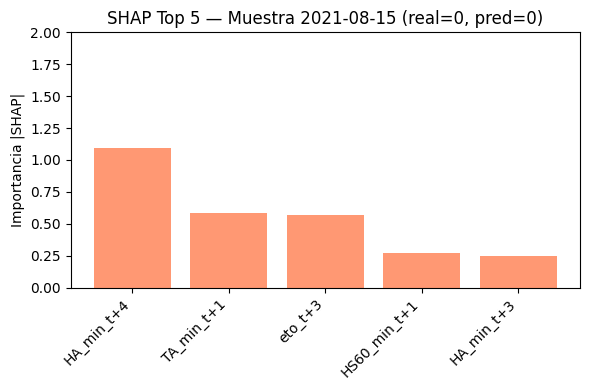


Muestra 1 - idx 2021-06-19
  Tipo de shap_values: <class 'numpy.ndarray'>
  -> Clasificación binaria detectada


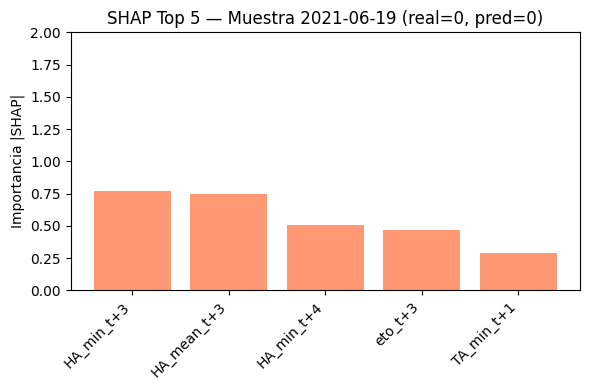


Muestra 2 - idx 2021-05-27
  Tipo de shap_values: <class 'numpy.ndarray'>
  -> Clasificación binaria detectada


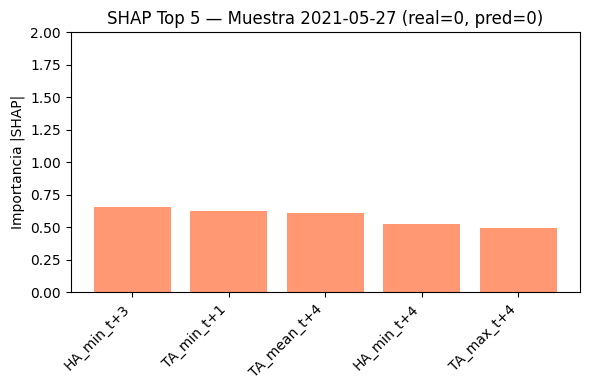


Muestra 3 - idx 2021-11-06
  Tipo de shap_values: <class 'numpy.ndarray'>
  -> Clasificación binaria detectada


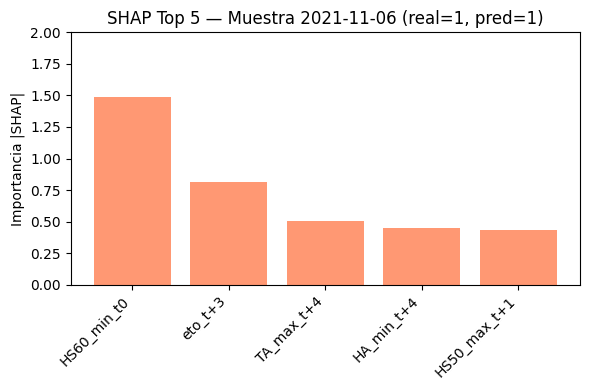


Muestra 4 - idx 2021-09-10
  Tipo de shap_values: <class 'numpy.ndarray'>
  -> Clasificación binaria detectada


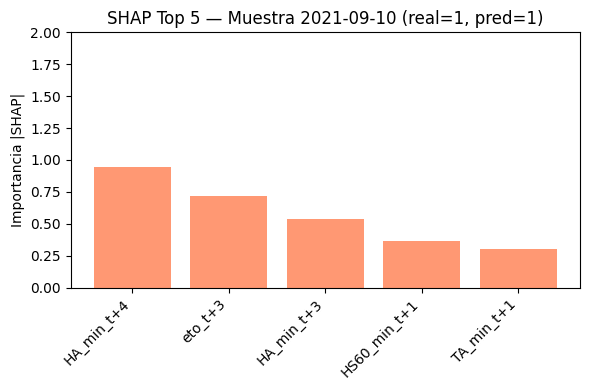


Muestra 5 - idx 2021-08-23
  Tipo de shap_values: <class 'numpy.ndarray'>
  -> Clasificación binaria detectada


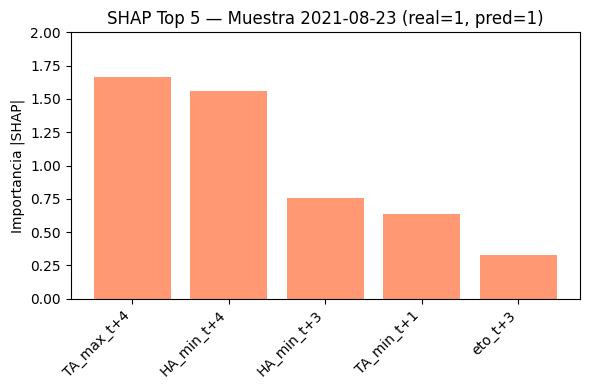

In [ ]:
# 1) Prepara las features y etiquetas del test (XGBoost)
X_shap = X_test_sel.copy()
y_true = y_test
y_pred = xgb_best.predict(X_test_sel)

# 2) Selecciona ejemplos bien clasificados (3 por clase)
idx_crece   = X_shap[(y_true == 0) & (y_pred == 0)].index[:3]
idx_decrece = X_shap[(y_true == 1) & (y_pred == 1)].index[:3]
selected_idx = list(idx_crece) + list(idx_decrece)

# 3) Crea el explainer optimizado para árboles (con fix)
booster = xgb_best.get_booster()
booster.set_param({"predictor": "cpu_predictor"})  # ← evita conflicto
explainer = shap.TreeExplainer(booster)

# 4) Calcula SHAP values solo para esas muestras
X_explain = X_shap.loc[selected_idx]
shap_values = explainer.shap_values(X_explain)

# 5) Extrae y grafica las top 5 características por individuo
feature_names = X_explain.columns
top_n = 5
type(y_pred), type(y_true), selected_idx[:5]

# Asegura que y_pred tiene el mismo índice que X_test_sel
y_pred_series = pd.Series(y_pred, index=X_test_sel.index)

for i, idx in enumerate(selected_idx):
    true_cls = int(y_true.loc[idx])
    pred_cls = int(y_pred_series.loc[idx])  # ← CORREGIDO

    print(f"\nMuestra {i} - idx {idx}")
    print(f"  Tipo de shap_values: {type(shap_values)}")
    
    if isinstance(shap_values, list):
        print("  -> Multiclase detectado")
        vals = shap_values[pred_cls][i]
    else:
        print("  -> Clasificación binaria detectada")
        vals = shap_values[i]

    abs_vals = np.abs(vals)
    top_idx   = np.argsort(abs_vals)[-top_n:][::-1]
    top_feats = feature_names[top_idx]
    top_vals  = abs_vals[top_idx]
    
    plt.figure(figsize=(6,4))
    plt.bar(top_feats, top_vals, color='coral', alpha=0.8)
    plt.title(f"SHAP Top {top_n} — Muestra {idx} (real={true_cls}, pred={pred_cls})")
    plt.ylabel("Importancia |SHAP|")
    plt.ylim(0, 2)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


In [ ]:
# Dataset para DiCE
df_dice = X_train_sel.copy()
df_dice['y'] = y_train

# Variables continuas
continuous = [c for c in df_dice.columns if c != 'y']

# Variables controlables por el agricultor
controllable_prefixes = ['HS10','HS20','HS30','HS40','HS50','HS60','TS30']
features_to_vary = [c for c in df_dice.columns if any(c.startswith(pref) for pref in controllable_prefixes)]

data_interface = dice_ml.Data(
    dataframe=df_dice,
    continuous_features=continuous,
    outcome_name='y'
)

# Wrapper para XGBoost (devuelve predict_proba como ndarray)
class XGBoostWrapper:
    def __init__(self, model, feature_names):
        self.model = model
        self.feature_names = feature_names
    def predict_proba(self, X):
        X = X[self.feature_names]
        return self.model.predict_proba(X).astype(np.float64)

model_interface = dice_ml.Model(
    model=XGBoostWrapper(xgb_best, X_train_sel.columns.tolist()),
    backend="sklearn"
)

exp = Dice(
    data_interface=data_interface,
    model_interface=model_interface,
    method="random"
)

# Selecciona ejemplo de contracción bien clasificado
mask = (y_test == 1) & (xgb_best.predict(X_test_sel) == 1)
idx = np.where(mask)[0][0]  # primer índice válido
X_query = X_test_sel.iloc[[idx]].reset_index(drop=True)

# Generar contrafactuales (pasar a clase 0: "crece")
cf = exp.generate_counterfactuals(
    X_query,
    total_CFs=3,
    desired_class=0,
    features_to_vary=features_to_vary,
    random_seed=7
)

# Mostrar solo los cambios respecto al original
cf.visualize_as_dataframe(show_only_changes=True)


100%|██████████| 1/1 [00:00<00:00,  5.80it/s]

Query instance (original outcome : 1)


,TA_max_t+4,HS50_max_t+1,eto_t+3,HA_min_t+4,TA_min_t+1,precipitacion_t+3,HS60_mean_t+1,radiacion_t-1,HA_min_t+3,HA_mean_t+3,HS60_min_t0,TA_mean_t+4,HS60_min_t+1,HS30_max_t0,HS10_min_t0,HS10_min_t+4,y
0,20.52,0.8002,1.44,0.3949,1.99,0.0,0.788199,11.78,0.4858,0.6783,0.7872,14.02,0.7863,0.7902,0.7544,0.7476,1



Diverse Counterfactual set (new outcome: 0)


,TA_max_t+4,HS50_max_t+1,eto_t+3,HA_min_t+4,TA_min_t+1,precipitacion_t+3,HS60_mean_t+1,radiacion_t-1,HA_min_t+3,HA_mean_t+3,HS60_min_t0,TA_mean_t+4,HS60_min_t+1,HS30_max_t0,HS10_min_t0,HS10_min_t+4,y
0,-,-,-,-,-,-,-,-,-,-,-,-,0.8027,0.7633,-,-,0.0
1,-,-,-,-,-,-,-,-,-,-,-,-,0.8138,-,0.7961,-,0.0
2,-,-,-,-,-,-,0.8071425,-,-,-,-,-,-,-,-,0.7617,0.0


In [ ]:
# Filtra ejemplos bien clasificados como 'contracción' (y = 1)
mask = (y_test == 1) & (xgb_best.predict(X_test_sel) == 1)
positions = np.where(mask)[0]

print(f"Se encontraron {len(positions)} ejemplos bien clasificados como 'decrece'.")

# 5 ejemplos para generar contrafactuales
for i, idx in enumerate(positions[:5]):
    print(f"\n📌 Ejemplo {i+1} en la posición {idx}:")

    X_query = X_test_sel.iloc[[idx]].reset_index(drop=True)

    cf = exp.generate_counterfactuals(
        X_query,
        total_CFs=3,
        desired_class=0,
        features_to_vary="all",
        random_seed=42
    )

    display(cf.visualize_as_dataframe(show_only_changes=True))


Se encontraron 4 ejemplos bien clasificados como 'decrece'.

📌 Ejemplo 1 en la posición 18:


100%|██████████| 1/1 [00:00<00:00,  4.44it/s]

Query instance (original outcome : 1)


,TA_max_t+4,HS50_max_t+1,eto_t+3,HA_min_t+4,TA_min_t+1,precipitacion_t+3,HS60_mean_t+1,radiacion_t-1,HA_min_t+3,HA_mean_t+3,HS60_min_t0,TA_mean_t+4,HS60_min_t+1,HS30_max_t0,HS10_min_t0,HS10_min_t+4,y
0,20.52,0.8002,1.44,0.3949,1.99,0.0,0.788199,11.78,0.4858,0.6783,0.7872,14.02,0.7863,0.7902,0.7544,0.7476,1



Diverse Counterfactual set (new outcome: 0)


,TA_max_t+4,HS50_max_t+1,eto_t+3,HA_min_t+4,TA_min_t+1,precipitacion_t+3,HS60_mean_t+1,radiacion_t-1,HA_min_t+3,HA_mean_t+3,HS60_min_t0,TA_mean_t+4,HS60_min_t+1,HS30_max_t0,HS10_min_t0,HS10_min_t+4,y
0,-,-,6.41,-,-,-,-,-,-,-,-,-,-,-,-,0.7875,0.0
1,-,-,-,-,-,-,-,-,-,-,0.823,-,-,-,-,-,0.0
2,-,-,-,-,-,-,-,19.51,-,-,-,-,-,-,-,-,0.0


None


📌 Ejemplo 2 en la posición 25:


100%|██████████| 1/1 [00:00<00:00,  4.13it/s]

Query instance (original outcome : 1)


,TA_max_t+4,HS50_max_t+1,eto_t+3,HA_min_t+4,TA_min_t+1,precipitacion_t+3,HS60_mean_t+1,radiacion_t-1,HA_min_t+3,HA_mean_t+3,HS60_min_t0,TA_mean_t+4,HS60_min_t+1,HS30_max_t0,HS10_min_t0,HS10_min_t+4,y
0,30.51,0.8193,1.95,0.2857,17.92,0.41,0.80958,20.42,0.5047,0.731,0.8056,23.620001,0.8053,0.6835,0.6792,0.687,1



Diverse Counterfactual set (new outcome: 0)


,TA_max_t+4,HS50_max_t+1,eto_t+3,HA_min_t+4,TA_min_t+1,precipitacion_t+3,HS60_mean_t+1,radiacion_t-1,HA_min_t+3,HA_mean_t+3,HS60_min_t0,TA_mean_t+4,HS60_min_t+1,HS30_max_t0,HS10_min_t0,HS10_min_t+4,y
0,-,-,-,-,9.0,-,-,-,-,-,-,-,-,-,-,-,0.0
1,-,-,-,-,11.73,-,-,-,-,-,0.8004,-,-,-,-,-,0.0
2,-,-,3.26,-,-,-,-,-,-,-,-,17.06,-,-,-,-,0.0


None


📌 Ejemplo 3 en la posición 26:


100%|██████████| 1/1 [00:00<00:00,  3.85it/s]

Query instance (original outcome : 1)


,TA_max_t+4,HS50_max_t+1,eto_t+3,HA_min_t+4,TA_min_t+1,precipitacion_t+3,HS60_mean_t+1,radiacion_t-1,HA_min_t+3,HA_mean_t+3,HS60_min_t0,TA_mean_t+4,HS60_min_t+1,HS30_max_t0,HS10_min_t0,HS10_min_t+4,y
0,37.220001,0.8414,4.97,0.2074,21.059999,0.0,0.816877,18.51,0.3302,0.6639,0.8128,26.959999,0.8116,0.8211,0.7352,0.7015,1



Diverse Counterfactual set (new outcome: 0)


,TA_max_t+4,HS50_max_t+1,eto_t+3,HA_min_t+4,TA_min_t+1,precipitacion_t+3,HS60_mean_t+1,radiacion_t-1,HA_min_t+3,HA_mean_t+3,HS60_min_t0,TA_mean_t+4,HS60_min_t+1,HS30_max_t0,HS10_min_t0,HS10_min_t+4,y
0,-,-,-,0.4544,-,35.0,-,-,-,-,-,-,-,-,-,-,0.0
1,32.57,-,-,-,-,-,-,-,-,-,0.8063,-,-,-,-,-,0.0
2,-,-,-,-,-,-,-,-,-,0.463,-,-,-,0.709,-,-,0.0


None


📌 Ejemplo 4 en la posición 40:


100%|██████████| 1/1 [00:00<00:00,  4.00it/s]

Query instance (original outcome : 1)


,TA_max_t+4,HS50_max_t+1,eto_t+3,HA_min_t+4,TA_min_t+1,precipitacion_t+3,HS60_mean_t+1,radiacion_t-1,HA_min_t+3,HA_mean_t+3,HS60_min_t0,TA_mean_t+4,HS60_min_t+1,HS30_max_t0,HS10_min_t0,HS10_min_t+4,y
0,37.919998,0.8407,6.39,0.191,18.440001,0.0,0.821154,23.030001,0.2527,0.6886,0.816,27.77,0.8156,0.8253,0.7628,0.7516,1



Diverse Counterfactual set (new outcome: 0)


,TA_max_t+4,HS50_max_t+1,eto_t+3,HA_min_t+4,TA_min_t+1,precipitacion_t+3,HS60_mean_t+1,radiacion_t-1,HA_min_t+3,HA_mean_t+3,HS60_min_t0,TA_mean_t+4,HS60_min_t+1,HS30_max_t0,HS10_min_t0,HS10_min_t+4,y
0,-,-,-,0.4544,-,35.0,-,-,-,-,-,-,-,-,-,-,0.0
1,-,-,-,-,4.27,-,-,-,-,-,-,-,-,-,0.6914,-,0.0
2,-,-,-,0.3444,-,-,-,-,-,-,-,-,-,-,-,-,0.0


None